# 예측

출처: https://github.com/jaron/deep-listening/blob/master/2-us8k-ffn-train-predict.ipynb


Workbook 2 - Training a Feed-Forward Neural Network using UrbanSound8K audio data

> 통합 문서 2 - UrbanSound8K 오디오 데이터를 사용하여 피드 포워드 신경망 훈련

This loads the features we extracted using librosa (see workbook 1), and uses them to train a Feed-Forward Network, a simple deep neural net with a few hidden layers, and then predict the class of a set of previously unheard audio files. You will need librosa, keras and tensorflow installed to run this code, and the latest version of scikit-learn (currently 0.18.1).

> 이렇게 하면 librosa (통합 문서 1 참조)를 사용하여 추출한 기능을 로드하고 숨겨진 레이어가 있는 간단한 신경망인 Feed-Forward 네트워크를 학습한 다음 이전에 들리지 않은 오디오 파일 세트의 클래스를 예측할 수 있습니다. 이 코드를 실행하기 위해 설치된 librosa, keras 및 tensorflow와 최신 scikit-learn 버전이 필요합니다.

## 패키지 설치
```shell
pip install keras tensorflow sklearn h5py
```


In [11]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

This code below loads previously computed numpy features for each of the 10 folds, we'll use the first 8 for training, and keep one back for validation and one for testing.

> 이 코드는 이전에 계산된 10개의 폴드에 대해서 numpy 피쳐를 로드합니다. 
> 처음 8개는 트레이닝에 사용하며 1개는 유효성 확인을 위해서 마지막 1개는 테스트를 위해서 유지합니다. 


In [12]:
data_dir = 'data/us8k-np-ffn'

def add_folds():
    subsequent_fold = False
    for k in range(1, 9):
        fold_name = 'fold' + str(k)
        print('Adding ' + fold_name)
        feature_file = os.path.join(data_dir, fold_name + '_x.npy')
        labels_file = os.path.join(data_dir, fold_name + '_y.npy')
        loaded_features = np.load(feature_file)
        loaded_labels = np.load(labels_file)
        print("New Features: ", loaded_features.shape)
        
        if subsequent_fold:
            features = np.concatenate((features, loaded_features))
            labels = np.concatenate((labels, loaded_labels))
        else:
            features = loaded_features
            labels = loaded_labels
            subsequent_fold = True
        
    return features, labels    
    
train_x, train_y = add_folds()

Adding fold1
New Features:  (873, 193)
Adding fold2
New Features:  (888, 193)
Adding fold3
New Features:  (925, 193)
Adding fold4
New Features:  (990, 193)
Adding fold5
New Features:  (936, 193)
Adding fold6
New Features:  (823, 193)
Adding fold7
New Features:  (838, 193)
Adding fold8
New Features:  (806, 193)


In [13]:
valid_fold_name = 'fold9'
feature_file = os.path.join(data_dir, valid_fold_name + '_x.npy')
labels_file = os.path.join(data_dir, valid_fold_name + '_y.npy')
valid_x = np.load(feature_file)
valid_y = np.load(labels_file)

# and a fold for testing
test_fold_name = 'fold10'
feature_file = os.path.join(data_dir, test_fold_name + '_x.npy')
labels_file = os.path.join(data_dir, test_fold_name + '_y.npy')
test_x = np.load(feature_file)
test_y = np.load(labels_file)

print("Training Set Features: {} Labels: {}".format(str(train_x.shape), str(train_y.shape)))
print("Validation Set Features: {} Labels: {}".format(str(valid_x.shape), str(valid_y.shape)))
print("Test Set Features: {} Labels: {}".format(str(test_x.shape), str(test_y.shape)))

Training Set Features: (7079, 193) Labels: (7079, 10)
Validation Set Features: (816, 193) Labels: (816, 10)
Test Set Features: (837, 193) Labels: (837, 10)


In [14]:
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

E:\4.SDK\Miniconda3_64\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [15]:
def assure_path_exists(path):
    mydir = os.path.join(os.getcwd(), path)
    if not os.path.exists(mydir):
        os.makedirs(mydir)

# neural network dimensions
n_dim = train_x.shape[1]
n_classes = train_y.shape[1]
n_hidden_units_1 = n_dim
n_hidden_units_2 = 400 # approx n_dim + 2
n_hidden_units_3 = 200 # half of layer 2

checkpoint_dir = "model"
assure_path_exists(checkpoint_dir)

print("Features: {} Classes: {}".format(n_dim, n_classes))

Features: 193 Classes: 10


In [16]:
train_x.shape

(7079, 193)

### 변경사항

init_type → `kernel_initializer`

> model.add(Dense(n_hidden_units_2, kernel_initializer=init_type, activation=activation_function))

nb_epoch → `epochs`

> history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[earlystop], epochs=30, batch_size=24)            

In [26]:
tf.set_random_seed(0)
np.random.seed(0)

def create_model(activation_function="relu", init_type="normal", optimiser="Adamax", dropout_rate=0.5):
    model = Sequential()
    # layer 1
    model.add(Dense(n_hidden_units_1, input_dim=n_dim))
    # layer 2
    model.add(Dense(n_hidden_units_2, kernel_initializer=init_type, activation=activation_function))
    model.add(Dropout(dropout_rate))
    # layer 3
    model.add(Dense(n_hidden_units_3, kernel_initializer=init_type, activation=activation_function))
    model.add(Dropout(dropout_rate))
    # output layer
    model.add(Dense(n_classes, kernel_initializer=init_type, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['accuracy'])
    return model

# a stopping function to stop trainning before we excessively overfit to the training set
earlystop = EarlyStopping(monitor = 'val_loss', patience=10, verbose =1, mode='auto')

model = create_model()

history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[earlystop], epochs=30, batch_size=24)            

Train on 7079 samples, validate on 816 samples
Epoch 1/30
7079/7079 [==============================] - 3s 449us/step - loss: 3.6058 - acc: 0.2846 - val_loss: 1.9590 - val_acc: 0.3162
Epoch 2/30
7079/7079 [==============================] - 2s 262us/step - loss: 1.9374 - acc: 0.4153 - val_loss: 1.9507 - val_acc: 0.4056
Epoch 3/30
7079/7079 [==============================] - 2s 260us/step - loss: 1.7341 - acc: 0.4592 - val_loss: 1.4919 - val_acc: 0.4743
Epoch 4/30
7079/7079 [==============================] - 2s 259us/step - loss: 1.5685 - acc: 0.5094 - val_loss: 1.4534 - val_acc: 0.5123
Epoch 5/30
7079/7079 [==============================] - 2s 261us/step - loss: 1.4271 - acc: 0.5464 - val_loss: 1.4269 - val_acc: 0.5429
Epoch 6/30
7079/7079 [==============================] - 2s 275us/step - loss: 1.3163 - acc: 0.5848 - val_loss: 1.4552 - val_acc: 0.5196
Epoch 7/30
7079/7079 [==============================] - 2s 261us/step - loss: 1.2530 - acc: 0.6011 - val_loss: 1.4389 - val_acc: 0.5576
E

## Measuring Accuracy

In [18]:
from sklearn import metrics
from keras.utils import np_utils

# obtain the prediction probabilities
y_prob = model.predict_proba(test_x, verbose=0)
# y_pred = np_utils.probas_to_classes(y_prob)
y_pred = model.predict_classes(test_x)
y_true = np.argmax(test_y, 1)

roc = metrics.roc_auc_score(test_y, y_prob)
print("ROC: ", round(roc, 2))

# evaluate the model
score, accuracy = model.evaluate(test_x, test_y, batch_size=32)
print("Accuracy = {: .2f}".format(accuracy))

p, r, f, s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print('F-Score: ', round(f, 2))

ROC:  0.89
837/837 [==============================] - 0s 56us/step
Accuracy =  0.57
F-Score:  0.57


I used GridSearch (see section below) to investigate the best combinations of parameters, such as optimisers, dropout rates, hidden layers and activation functions. With 2 hidden layers the best accuracy I observed was an F-score of 0.59 (ROC = 0.89)

With 3 hidden layers the best accuracy seen was an F-score of 0.645 (ROC=0.92), using the Adamax optimiser and a dropout rate of 0.5. There did not seem to be any benefit in using 4 hidden layers, the accuracy seemed equivalent to that achieved with just 2 hidden layers. (As the gradient computation is stochastic, you might get slightly different values when you run this code).

ROC curves are typically used in binary classification, so to apply this measure to multi-class classification, it's first necessary to convert the predictions into boolean values, each representing positive or negative predictions for each possible class. This enables us to draw one ROC curve per class, or draw a composite ROC curve by using micro-averaging.

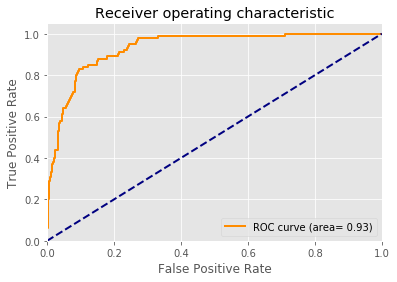

In [19]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(test_y.ravel(), y_prob.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange', lw=lw, label='ROC curve (area= %0.2f)' % roc_auc[2])
plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix

labels = ['aircon', 'horn', 'child', 'dog', 'drill', 'engine', 'gun', 'hammer', 'siren', 'music']
print("Confusion_matrix")
cm = confusion_matrix(y_true, y_pred)

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [7]) # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    ", empty_cell, end="")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end="")
    print()
    # Print rows
    for i, label in enumerate(labels):
        print("     %{0}s".format(columnwidth) % label, end="")
        for j in range(len(labels)):
            cell = "%{0}s".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end="")
        print()

print_cm(cm, labels)

Confusion_matrix
             aircon   horn  child    dog  drill engine    gun hammer  siren  music
      aircon     42      0      8      0      0      6      0     27      4     13
        horn      1     24      1      0      1      0      0      1      1      4
       child      0      1     79      9      0      1      0      0      5      5
         dog      3      1     14     60      2      2      0      1      6     11
       drill      0      2     13      0     21      0      0     29     10     25
      engine      2      0     26      1      0     50      0      6      1      7
         gun      0      0      4     16      0      0     10      0      2      0
      hammer      0      0      7      0     13      0      0     75      0      1
       siren      3      4     26      0      0      0      0      0     49      1
       music      1      2     17      0      5      4      0      3      0     68


### Refinement and Optimisation

The performance of a deep neural network is highly dependent on many configurable hyper-parameters, values that govern how the model actually works, and which are not changed during the course of learning. Some of these parameters will have a greater influence than others. The classic machine learning solution to this challenge is GridSearch, to successively train separate instances of a model with distinct values of key parameters, and then compare the resulting accuracy scores to identify which combination of parameters has produced the best results.

Scikit-Learn provides GridSearch functionality that can be adapted for use with a neural network implemented using Keras, as described here: http://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/.

Because the training process is computationally intensive, and must be repeated for each combination of hyper-parameter values, optimisation can be a slow, time-consuming process. The code below shows how the 3-layer network was trained with different stochastic gradient optimisers (https://keras.io/optimizers/), and reveals which algorithms work best for this particular problem domain.



In [21]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.constraints import maxnorm

activations = ['relu', 'tanh', 'linear']
batch_sizes = [10, 20, 30, 40, 50, 60]
epochs = [10, 20, 30]
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

optimisers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=24, verbose=0)

# define the grid search parameters
# just using one here for illustration, but add activation_function=activations
# or dropout_rate=dropout_rates to grid search on other parameters
param_grid = dict(optimiser=optimisers)
grid = GridSearchCV(estimator = model, param_grid=param_grid, n_jobs=1)

print("Running GridSearch...")
grid_result = grid.fit(train_x, train_y)
print("GridSearch complete")

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Running GridSearch...
GridSearch complete
Best: 0.471959 using {'optimiser': 'Adamax'}
0.394123 (0.016210) with: {'optimiser': 'SGD'}
0.456562 (0.029617) with: {'optimiser': 'RMSprop'}
0.469558 (0.028627) with: {'optimiser': 'Adagrad'}
0.452606 (0.024678) with: {'optimiser': 'Adadelta'}
0.468569 (0.029817) with: {'optimiser': 'Adam'}
0.471959 (0.048842) with: {'optimiser': 'Adamax'}
0.447380 (0.024561) with: {'optimiser': 'Nadam'}


## Generating Predictions

Once we've trained a model, we can use the following process to pass an audio file into our model and generate predictions, which will be the activation value (between 0 and 1) at the output layer for each of the 10 possible classes. Collectively, all the activations will sum to 1, meaning we can use argmax to show what the network's best guess is, as a well as providing a measure of its confidence.

> 모델을 훈련하고 나면 다음 프로세스를 사용하여 오디오 파일을 모델에 전달하고 10 개의 가능한 클래스 각각에 대해 출력 레이어에서 활성화 값 (0과 1 사이)이 될 예측을 생성 할 수 있습니다. 총체적으로 모든 활성화는 1로 합쳐질 것입니다. 즉 argmax를 사용하여 네트워크의 가장 좋은 추측을 보여줄 수 있습니다. 이는 자신감의 척도를 제공함은 물론입니다.

The following fragment considers 10 different audio samples, one for each class, showing the model's best guess (highest activation value), as well as the second best guess, which can provide useful insights in those cases where the model misidentifies the sample. After all, as you can see from the results, the predictions are not perfect.

> 다음 단편은 모델의 가장 적합한 추측 값 (가장 높은 활성화 값)과 두 번째로 가장 좋은 추측을 보여주는 각기 다른 10 개의 오디오 샘플을 고려하여 모델이 샘플을 잘못 식별하는 경우 유용한 통찰을 제공합니다. 결국 결과에서 알 수 있듯이 예측은 완벽하지 않습니다.

In [22]:
import librosa

sound_file_paths = ["aircon.wav", "carhorn.wav", "play.wav", "dogbark.wav", "drill.wav",
                    "engine.wav","gunshots.wav","jackhammer.wav","siren.wav","music.wav"]
sound_names = ["air conditioner","car horn","children playing","dog bark","drilling","engine idling",
               "gun shot","jackhammer","siren","street music"]
parent_dir = 'samples/'

In [23]:
# just extract the features, 
def extract_features_only(filename):
    features = np.empty((0,193))
    X, sample_rate = librosa.load(filename)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
    features = np.vstack([features,ext_features])
    return features

In [27]:
# create predictions for each of the sound classes
for s in range(len(sound_names)):

    print("\n----- ", sound_names[s], "-----")
    # load audio file and extract features
    predict_file = parent_dir + sound_file_paths[s]
    predict_x = extract_features_only(predict_file)
    
    # generate prediction, passing in just a single row of features
    predictions = model.predict(predict_x)
    
    #for i in range(len(predictions[0])):
    #    print sound_names[i], "=", round(predictions[0,i] * 100, 1)
    
    # get the indices of the top 2 predictions, invert into descending order
    ind = np.argpartition(predictions[0], -2)[-2:]
    ind[np.argsort(predictions[0][ind])]
    ind = ind[::-1]
    
    print("Top guess: ", sound_names[ind[0]], " (",round(predictions[0,ind[0]],3),")")
    print("2nd guess: ", sound_names[ind[1]], " (",round(predictions[0,ind[1]],3),")")


-----  air conditioner -----
Top guess:  air conditioner  ( 0.747 )
2nd guess:  street music  ( 0.134 )

-----  car horn -----
Top guess:  car horn  ( 0.961 )
2nd guess:  jackhammer  ( 0.036 )

-----  children playing -----
Top guess:  children playing  ( 0.538 )
2nd guess:  street music  ( 0.231 )

-----  dog bark -----
Top guess:  dog bark  ( 1.0 )
2nd guess:  gun shot  ( 0.0 )

-----  drilling -----
Top guess:  children playing  ( 0.384 )
2nd guess:  dog bark  ( 0.241 )

-----  engine idling -----
Top guess:  engine idling  ( 0.992 )
2nd guess:  children playing  ( 0.004 )

-----  gun shot -----
Top guess:  dog bark  ( 0.413 )
2nd guess:  gun shot  ( 0.213 )

-----  jackhammer -----
Top guess:  jackhammer  ( 0.526 )
2nd guess:  drilling  ( 0.222 )

-----  siren -----
Top guess:  drilling  ( 0.473 )
2nd guess:  engine idling  ( 0.224 )

-----  street music -----
Top guess:  street music  ( 0.996 )
2nd guess:  car horn  ( 0.003 )


## Evaluating Convergence

There is also valuable information about learning performance in the history object. This can, for instance, reveal the speed of convergence over epochs, initially a slope, which may ultimately plateau out. Whether the mode may be over-learning the training data (inflection for validation line).

> 또한 히스토리 오브젝트에서 학습 성능에 대한 중요한 정보가 있습니다. 예를 들어, 이것은 초기에 수렴하는 속도를 나타낼 수 있으며, 처음에는 경사가 되어 결국 궁극적으로 고원 상태가 될 수 있습니다. 모드가 교육 데이터를 과도하게 학습하는지 여부 (유효성 검사 행에 대한 굴절)

From the plot of accuracy indicates whether the model could be trained further (if the accuracy trend is still rising for the final epochs). It will also indicate if the model has over-learned the training dataset, it should show comparable performance on both train and test datasets.

> 정확도 플롯에서 모델이 더 훈련 될 수 있는지 여부를 나타냅니다 (정확도 추세가 최종 신기원에 대해 여전히 상승하는 경우). 모델이 훈련 데이터 세트를 과도하게 학습했는지 여부는 열차 및 테스트 데이터 세트 모두에서 비교 가능한 성능을 나타내야합니다.

If the model is overfitting the accuracy graph will show excellent performance on the training data, and poor performance on the test data.

> 모델이 초과 적용되면 정확도 그래프는 교육 데이터에서 우수한 성능을 나타내며 테스트 데이터에서 성능이 떨어집니다.

Ideally, in the loss graph, we should see comparable performance in both the training and validation datasets. Should these parallel plots start to diverge, it might be a indication we should stop training earlier. For a more detailed explanation, see http://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

> 이상적으로 손실 그래프에서 우리는 교육 및 검증 데이터 세트 모두에서 비교 가능한 성능을 보여야 합니다. 이 평행선이 갈라지기 시작하면 일찍 훈련을 중단해야한다는 표시 일 수 있습니다. 자세한 설명은 http://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/ 를 참조하십시오.

History keys dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


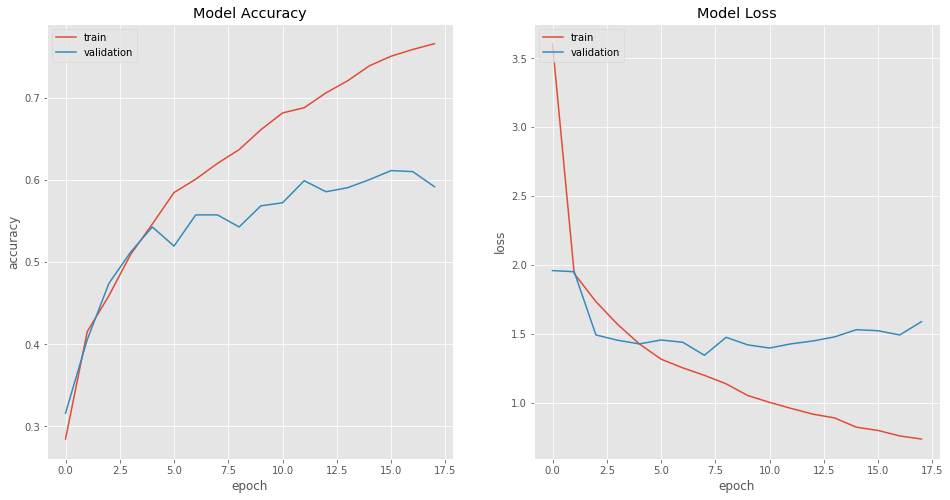

In [29]:
fig = plt.figure(figsize=(16,8))

print("History keys", (history.history.keys()))
# summarise history for training and validation set accuracy
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarise history for training and validation set loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()